<a href="https://colab.research.google.com/github/Tower5954/TensorFlow/blob/main/06_Transfer_Learning_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning part.3

What we are going to cover:
* Downloading and preparing 10% of all Food101 classes (7500+ training images)
* Training a transfer learning feature extraction model
* Fine-tuning a feature extraction model to beat the original Food101 paper with only 10% of the data.
* Evaluating "Food Visions mini" predictions.
  * Finding the most wrong predictions (on the test data)
* Making predictions with Food Vision mini on our own custom data.

We have now seen the power of transfer learning feature extraction and fine-tuning, now it is time to scale up to all of the classes in food101 (101 total classes of food).

The goal is to beat the original food 101 paper with only 10% of the training (leveraging the power of deep learning).

 [Original Food101 paper.](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)

 The baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
# Set up GPU 
# Check to see if running a GPU

!nvidia-smi

Sun Jan 23 12:54:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we have created a series of helper functions.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-23 12:54:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-23 12:54:14 (49.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data.

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

> The data that we are downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [4]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-01-23 12:54:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   218MB/s    in 6.9s    

2022-01-23 12:54:25 (223 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



### Checking the data

In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fish_and_chips'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/frozen_yogurt'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ceviche'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ravioli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of the 101 Food Classes

The steps that we will take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we will create our output layer)
* Compile the model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)
 

### Create checkpoint callback

In [7]:
checkpoint_path = "101_classes_10_percent_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True) 

### Create data augmentation

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.models import Sequential 

# Setup data augmentation
data_augmentation = Sequential([
                      preprocessing.RandomFlip("horizontal"),
                      preprocessing.RandomRotation(0.2),
                      preprocessing.RandomHeight(0.2),
                      preprocessing.RandomWidth(0.2),
                      preprocessing.RandomZoom(0.2),
                     # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
                     
                      ],name="data-augmentation")

### Set up the base model and freeze it's layers (this will extract features)

In [11]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers

inputs = layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen.
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
# Get a summary of the model we have created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data-augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Compile the Model

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

### Fit the model

In [16]:
history_101_classes_10_percent_model = model.fit(train_data_all_10_percent,
                                                 epochs=5,
                                                 validation_data=test_data,
                                                 validation_steps=int(0.15*len(test_data)),
                                                 callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 72s 303ms/step - loss: 3.0663 - accuracy: 0.3909 - val_loss: 3.1045 - val_accuracy: 0.3808
Epoch 2/5
237/237 [==============================] - 67s 280ms/step - loss: 2.9199 - accuracy: 0.4129 - val_loss: 2.9706 - val_accuracy: 0.3980
Epoch 3/5
237/237 [==============================] - 66s 275ms/step - loss: 2.7851 - accuracy: 0.4352 - val_loss: 2.8574 - val_accuracy: 0.4105
Epoch 4/5
237/237 [==============================] - 64s 266ms/step - loss: 2.6699 - accuracy: 0.4499 - val_loss: 2.7547 - val_accuracy: 0.4253
Epoch 5/5
237/237 [==============================] - 62s 260ms/step - loss: 2.5723 - accuracy: 0.4569 - val_loss: 2.6695 - val_accuracy: 0.4372


### Evaluate the model 

In [17]:
fine_tuning_results = model.evaluate(test_data)

790/790 [==============================] - 101s 127ms/step - loss: 2.4461 - accuracy: 0.4723


In [18]:
fine_tuning_results

[2.446108818054199, 0.4722772240638733]

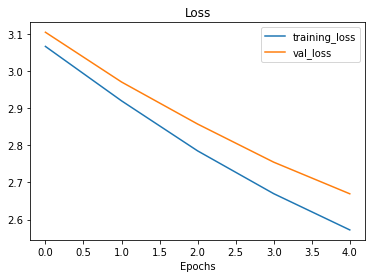

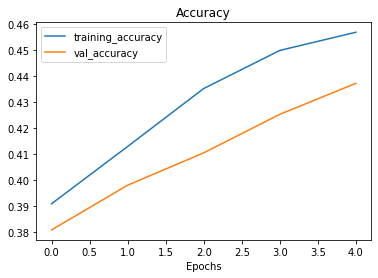

In [20]:
plot_loss_curves(history_101_classes_10_percent_model)